# OS Motifs

Plot for motifs recovered from high OSK model in transient early peaks. 

Another to compare OCT-SOX motifs between transient peaks from neural-like state and those from iPSC models.

**Inputs**:
1. MoDISco output on transient peaks for high OSK model
2. MoDISco output on all iPSC peaks for iPSC model

In [4]:
library(ggseqlogo)
library(ggplot2)
library(rhdf5)
library(patchwork)

## Loading Inputs

In [5]:
transient_h5f = H5Fopen("../../analysis/20210303_motif_affinity/modisco_runs/results_cluster_idx4_gc_neg_peak_set_8_10_11_13/modisco.hdf5")
ipsc_h5f = H5Fopen("~/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/modisco_2kb_50k/modisco_results_allChroms_counts.hdf5")

In [6]:
transient_patterns = transient_h5f&"metacluster_idx_to_submetacluster_results"&"metacluster_0"&"seqlets_to_patterns_result"&"patterns"
ipsc_patterns = ipsc_h5f&"metacluster_idx_to_submetacluster_results"&"metacluster_0"&"seqlets_to_patterns_result"&"patterns"

In [7]:
transient_os = transient_patterns&"pattern_0"
ipsc_os = ipsc_patterns&"pattern_1"

In [8]:
revcomp <- function(x) {
    x = x[rev(seq(nrow(x))), rev(seq(ncol(x)))]
    x
}

## Transient Motifs

In [90]:
trim_and_plot <- function(m, rc=F, trim_left=0, trim_right=0, method='bits', ymin=0, ymax=2, title=NULL) {
    if (rc) {
        m = revcomp(m)                
    }

    m = m[, trim_left:(ncol(m)-trim_right)]

    rownames(m) = c("A","C","G","T")
    
    p <- ggseqlogo(m, method=method, ncol=1) + 
                                    ylim(c(ymin,ymax)) +
                                    theme_void() 
    
    if (!is.null(title)) {
        p = p + ggtitle(title)
        p = p + theme(plot.title = element_text(hjust = 0.5, size=18))
    }
    
    p
}

In [70]:
trans_os_mot = (transient_patterns&"pattern_0"&"sequence"&"fwd")[]
trans_klf_mot = (transient_patterns&"pattern_1"&"sequence"&"fwd")[]
trans_ap1_mot = (transient_patterns&"pattern_2"&"sequence"&"fwd")[]
trans_sox_mot = (transient_patterns&"pattern_3"&"sequence"&"fwd")[]

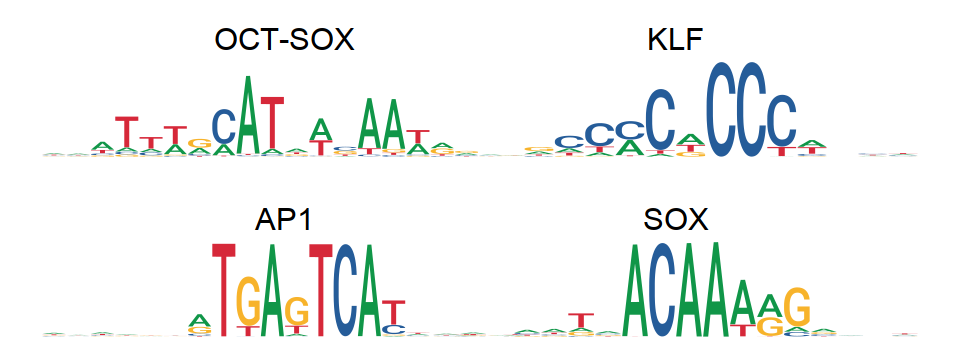

In [81]:
options(repr.plot.width = 8, repr.plot.height = 3)

MID = -0.3

top = wrap_plots(
        trim_and_plot(trans_os_mot, rc=T, trim_left=6, trim_right=5, title="OCT-SOX"),
        plot_spacer(),
        trim_and_plot(trans_klf_mot, rc=T, trim_left=3, trim_right=12, title="KLF"),
    widths=c(1,MID,1)
    )

bottom = wrap_plots(
    trim_and_plot(trans_ap1_mot, trim_left=11, trim_right=0, title="AP1"),
    plot_spacer(),
     trim_and_plot(trans_sox_mot, trim_left=11, trim_right=2, title="SOX"),
    widths=c(1,MID,1)
)

p <- wrap_plots(
    top,
    plot_spacer(),
    bottom,
    heights=c(1,0,1))

p

## Transient vs iPSCs

In [286]:
get_plots <- function(cur_pattern, rc=F, trim_left=0, trim_right=0, first_yaxis=F) {
    transient_plots = list()
    tot_instances = as.numeric(h5ls(cur_pattern&"seqlets_and_alnmts")[1,]$dim)
    
    cwm = (cur_pattern&"task0_contrib_scores"&"fwd")[]
    pwm = (cur_pattern&"sequence"&"fwd")[]
    
    transient_plots[[1]] = trim_and_plot(pwm,
                                         rc, trim_left, trim_right
                                        )
    
    transient_plots[[2]] = trim_and_plot(cwm,
                                         rc, trim_left, trim_right, method='custom',
                                         ymin=min(cwm)-0.01, ymax=max(cwm)+0.01
                                        )
    
    transient_plots[[3]] = ggplot() + theme_void() + annotate("segment", x=0, xend=1, y=0, yend=0)

    
    i = 4
    for (x in h5ls(cur_pattern&"subcluster_to_subpattern", recursive=1)$name) {
        if (x!="subcluster_names") {
            submotif = (cur_pattern&"subcluster_to_subpattern"&x&"sequence"&"fwd")[]
            num_instances = as.numeric(h5ls(cur_pattern&"subcluster_to_subpattern"&x&"seqlets_and_alnmts")[1,]$dim)
            
            transient_plots[[i]] = trim_and_plot(submotif, rc, trim_left, trim_right)

             transient_plots[[i]] = transient_plots[[i]] +
                                    annotate('text', 
                                             x=ncol(submotif)-trim_left-trim_right, 
                                             y=1, 
                                             size=7, 
                                             label=sprintf("%.2f", 100*(num_instances/tot_instances))) +
                                    annotate('text', 
                                            x=1,
                                            y=1.5,
                                             size=5,
                                            label=as.character(i-3)) +
                                    
            theme(plot.margin = unit(c(20,0,0,0), "pt"))
            
            if ((i==4) &&(first_yaxis)) {
                transient_plots[[i]] = transient_plots[[i]] + 
                theme_void() +
                scale_y_continuous(limits=c(0,2),
                                   breaks=c(0,1,2))  +
                theme(axis.title.y = element_blank(),
                      axis.text.y = element_text(margin = margin(0,5,0,0)),
                     axis.ticks.y = element_line(size=1,  linetype = "solid"),
                     axis.text.x = element_blank(),
                     axis.ticks.x = element_blank())
            }
        }
        
        i = i +1
    }    
    
    transient_plots
}

In [287]:
transient_plots = get_plots(transient_os, rc=T, trim_left=6, trim_right=5) #, first_yaxis = T)

In [288]:
ipsc_plots = get_plots(ipsc_os, trim_left=7, trim_right=4, first_yaxis = F)

In [289]:
TXTSZ=8

In [290]:
top_plot = ggplot() + annotate("text", x=2.5, y=1, label="Transient", size=TXTSZ) +
            annotate("text", x=7.5, y=1, label="iPSC", size=TXTSZ) +
            xlim(c(0,10)) + 
            theme_void()

In [297]:
left_plot = ggplot() + annotate("text", x=1, y=9.4, label="PWM", size=TXTSZ) +
            annotate("text", x=1, y=8.8, label="CWM", size=TXTSZ) +
            annotate("text", x=1, y=4.5, label="Subcluster\nPWM", angle=90, size=TXTSZ) +
            ylim(c(0,10)) + 
            theme_void()

In [302]:
pwm_cwm_submotifs <- wrap_plots(
                        wrap_plots(transient_plots, ncol=1),
                        plot_spacer(),
                        wrap_plots(wrap_plots(ipsc_plots, ncol=1),
                                   plot_spacer(),
                                   heights=c(9.5,2)),
                        widths=c(1,0,1)) 

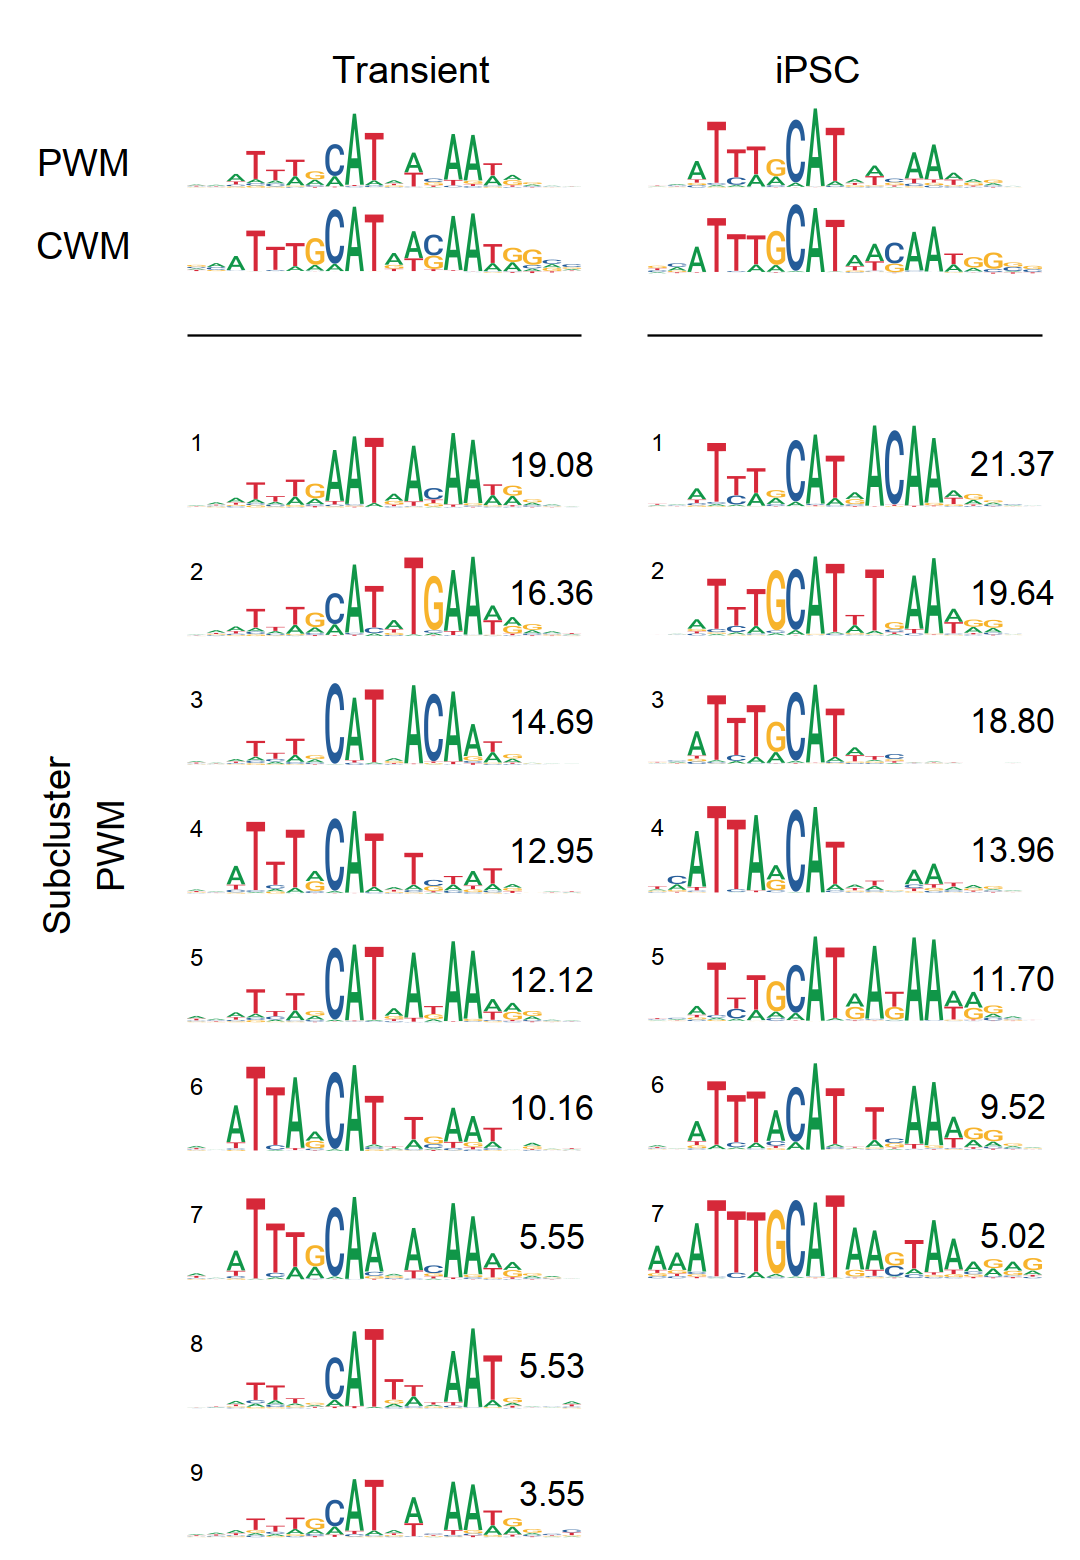

In [303]:
options(repr.plot.width = 9, repr.plot.height = 13)

wrap_plots(left_plot, 
           wrap_plots(top_plot, 
                      plot_spacer(),
                      pwm_cwm_submotifs,
                      heights=c(1,-0.5,12)),
           widths=c(2,12))

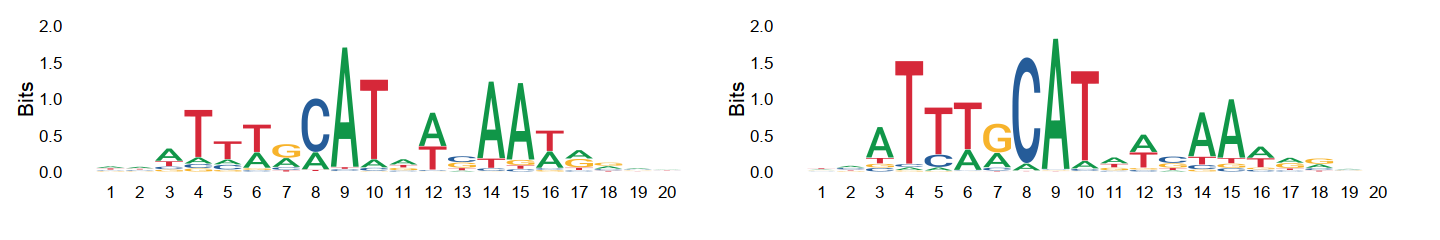

In [157]:
options(repr.plot.width = 12, repr.plot.height = 2)

transient_agg = (transient_os&"sequence"&"fwd")[]
transient_agg = revcomp(transient_agg)
transient_agg = transient_agg[, 6:25]
rownames(transient_agg) = c("A", "C", "G", "T")


iPSC_agg = (ipsc_os&"sequence"&"fwd")[]
iPSC_agg = iPSC_agg[, 7:26]
rownames(iPSC_agg) = c("A", "C", "G", "T")

(ggseqlogo(transient_agg) +
ylim(c(0,2))) |
(ggseqlogo(iPSC_agg) +
ylim(c(0,2)))

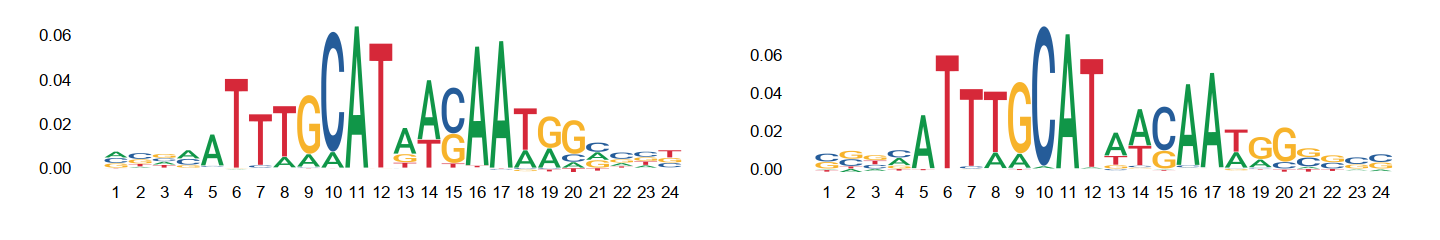

In [31]:
options(repr.plot.width = 12, repr.plot.height = 2)

transient_agg = (transient_os&"task0_contrib_scores"&"fwd")[]
transient_agg = revcomp(transient_agg)
transient_agg = transient_agg[, 4:27]
rownames(transient_agg) = c("A", "C", "G", "T")


iPSC_agg = (ipsc_os&"task0_contrib_scores"&"fwd")[]
iPSC_agg = iPSC_agg[, 5:28]
rownames(iPSC_agg) = c("A", "C", "G", "T")

ggseqlogo(transient_agg, method='custom')  |
ggseqlogo(iPSC_agg, method='custom') 

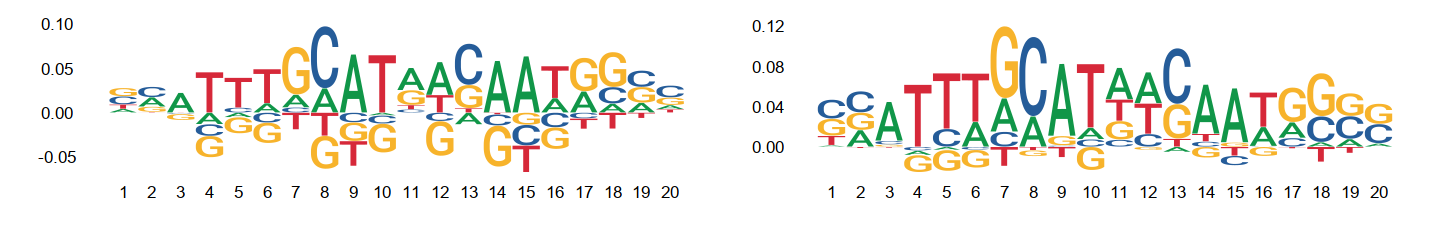

In [469]:
options(repr.plot.width = 12, repr.plot.height = 2)

transient_agg = (transient_os&"task0_hypothetical_contribs"&"fwd")[]
transient_agg = revcomp(transient_agg)
transient_agg = transient_agg[, 6:25]
rownames(transient_agg) = c("A", "C", "G", "T")


iPSC_agg = (ipsc_os&"task0_hypothetical_contribs"&"fwd")[]
iPSC_agg = iPSC_agg[, 7:26]
rownames(iPSC_agg) = c("A", "C", "G", "T")

ggseqlogo(transient_agg, method='custom')  |
ggseqlogo(iPSC_agg, method='custom') 